# Momentum Crossover Strategy

### Strategy description

We use RSI as an indicator of momentum and slow ema and fast ema to indicate trend direction

### Buy signal

1. The short-term SMA crosses above the long-term SMA. This crossover signals a potential upward trend.
2. The RSI crosses below 30 and then moves back above it. This suggests that the asset might be moving out of an oversold condition and starting to gain upward momentum.

### Sell signal

1. The short-term SMA crosses below the long-term SMA. This crossover signals a potential downward trend.
2. The RSI crosses above 70 and then moves back below it. This suggests that the asset might be moving out of an overbought condition and starting to lose upward momentum.

For both the buy and sell signals, the conditions should be ideally occur around the same time for a stronger signal.

## Set up

Set up the parameters used in in this strategy backtest study.

- Backtested blockchain, exchange and trading pair
- Backtesting period
- Strategy parameters for EMA crossovers

In [18]:
import datetime
import pandas as pd

from tradingstrategy.chain import ChainId
from tradingstrategy.timebucket import TimeBucket
from tradingstrategy.lending import LendingProtocolType
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency

# Tell what trade execution engine version this strategy needs to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.1"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
# PancakeSwap basic routing supports two way trades with BUSD
# and three way trades with BUSD-BNB hop.
TRADE_ROUTING = TradeRouting.uniswap_v3_usdc

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_1h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc

# Time bucket for our candles
CANDLE_TIME_BUCKET = TimeBucket.h1


# Which trading pair we are trading
TRADING_PAIR = (ChainId.polygon, "uniswap-v3", "WETH", "USDT", 0.00050) # Ether-Tether USD https://tradingstrategy.ai/trading-view/ethereum/uniswap-v2/eth-usdt

RESERVES = [
    (ChainId.polygon, LendingProtocolType.aave_v3, "USDT"),
]


# How much of the cash to put on a single trade
POSITION_SIZE = 0.70

#
# Strategy thinking specific parameter
#

BATCH_SIZE = 50

SLOW_EMA_CANDLE_COUNT = 15
FAST_EMA_CANDLE_COUNT = 5
RSI_CANDLE_COUNT = 5
LOOKBACK = 5

RSI_LOWER_THRESHOLD = 30
RSI_UPPER_THRESHOLD = 70

# Range of backtesting and synthetic data generation.
# Because we are using synthetic data actual dates do not really matter -
# only the duration

START_AT = datetime.datetime(2023, 1, 1)

END_AT = datetime.datetime(2024, 1, 1)

# Start with 10,000 USD
INITIAL_DEPOSIT = 10_000

# If the price drops 5 we trigger a stop loss
STOP_LOSS_PCT = 0.95

STOP_LOSS_TIME_BUCKET = TimeBucket.h1


## Strategy logic and trade decisions

- `decide_trades` function decide what trades to take.
- In this example, we calculate two exponential moving averages
(EMAs) and make decisions based on those.

### Indicators

- Note how we also make use of detached and overlayed technical indicators, so that the price chart is not overcrowded


In [19]:
from typing import List, Dict

from pandas_ta.overlap import ema
from pandas_ta import rsi

from tradeexecutor.state.visualisation import PlotKind, PlotShape
from tradeexecutor.utils.crossover import contains_cross_over, contains_cross_under
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradingstrategy.universe import Universe
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        strategy_universe: TradingStrategyUniverse,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
    """The brain function to decide the trades on each trading strategy cycle.

    - Reads incoming execution state (positions, past trades)

    - Reads the current universe (candles)

    - Decides what trades to do next, if any, at current timestamp.

    - Outputs strategy thinking for visualisation and debug messages

    :param timestamp:
        The Pandas timestamp object for this cycle. Matches
        TRADING_STRATEGY_CYCLE division.
        Always truncated to the zero seconds and minutes, never a real-time clock.

    :param universe:
        Trading universe that was constructed earlier.

    :param state:
        The current trade execution state.
        Contains current open positions and all previously executed trades, plus output
        for statistics, visualisation and diangnostics of the strategy.

    :param pricing_model:
        Pricing model can tell the buy/sell price of the particular asset at a particular moment.

    :param cycle_debug_data:
        Python dictionary for various debug variables you can read or set, specific to this trade cycle.
        This data is discarded at the end of the trade cycle.

    :return:
        List of trade instructions in the form of :py:class:`TradeExecution` instances.
        The trades can be generated using `position_manager` but strategy could also hand craft its trades.
    """
    universe = strategy_universe.universe

    # The pair we are trading
    pair = universe.pairs.get_single()

    # How much cash we have in the hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=BATCH_SIZE)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]


    # Calculate exponential moving averages based on slow and fast sample numbers.
    slow_ema_series = ema(close_prices, length=SLOW_EMA_CANDLE_COUNT)
    fast_ema_series = ema(close_prices, length=FAST_EMA_CANDLE_COUNT)
    rsi_series = rsi(close_prices, length=RSI_CANDLE_COUNT)


    slow_ema_latest = slow_ema_series.iloc[-1]
    fast_ema_latest = fast_ema_series.iloc[-1]
    price_latest = close_prices.iloc[-1]
    rsi_latest = rsi_series.iloc[-1]
    
    trades = []


    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    if not position_manager.is_any_long_position_open():
        # No open positions, decide if BUY in this cycle.
        
        # Buy Signal:
        #
        # 1. The short-term SMA crosses above the long-term SMA. This crossover signals a potential upward trend.
        # 2. The RSI crosses below 30 and then moves back above it. This suggests that the asset might be moving out of an oversold condition and starting to gain upward momentum.
        #
        # Both conditions should occur around the same time for a stronger buy signal.

        crossover_ema, ema_crossover_index = contains_cross_over(
            fast_ema_series,
            slow_ema_series, 
            lookback_period=LOOKBACK,
            must_return_index=True
        )
        crossunder_rsi_30, rsi_crossunder_index = contains_cross_under(
            rsi_series, 
            pd.Series([RSI_LOWER_THRESHOLD] * len(rsi_series)),
            lookback_period=LOOKBACK, 
            must_return_index=True
        )
        crossover_rsi_30, rsi_crossover_index = contains_cross_over(
            rsi_series, 
            pd.Series([RSI_LOWER_THRESHOLD] * len(rsi_series)),
            lookback_period=LOOKBACK,
            must_return_index=True
        )

        if (crossover_ema and crossunder_rsi_30 and crossover_rsi_30) \
            and (ema_crossover_index == -1 or rsi_crossover_index == -1) \
                and rsi_crossunder_index < rsi_crossover_index:
            
            # current_pos = None
            # close credit supply position before opening a new long position
            # assert position_manager.is_any_credit_supply_position_open(), "Credit supply position should be open"
            
            
            buy_amount = float(cash) * POSITION_SIZE
            
        
            new_trades = position_manager.open_spot(
                pair, 
                value=buy_amount,
                stop_loss_pct=STOP_LOSS_PCT
            )
            trades.extend(new_trades)
            # assert len(trades) in [1, 2]
    else:

        # Sell Signal:
        #
        # 1. The short-term SMA crosses below the long-term SMA. This crossover signals a potential downward trend.
        # 2. The RSI crosses above 70 and then moves back below it. This suggests that the asset might be moving out of an overbought condition and starting to lose upward momentum.
        # Again, for a stronger sell signal, both conditions should ideally occur around the same time.

        crossunder_ema, ema_crossunder_index = contains_cross_under(
            fast_ema_series,
            slow_ema_series, 
            lookback_period=LOOKBACK,
            must_return_index=True
        )
        crossunder_rsi_70, rsi_crossunder_index = contains_cross_under(
            rsi_series,
            pd.Series([RSI_UPPER_THRESHOLD] * len(rsi_series)), 
            lookback_period=LOOKBACK, 
            must_return_index=True
        )
        crossover_rsi_70, rsi_crossover_index = contains_cross_over(
            rsi_series,
            pd.Series([RSI_UPPER_THRESHOLD] * len(rsi_series)), 
            lookback_period=LOOKBACK, 
            must_return_index=True
        )

        if (crossunder_ema and crossover_rsi_70 and crossunder_rsi_70) \
            and (ema_crossunder_index == -1 or rsi_crossover_index == -1) \
            and rsi_crossover_index < rsi_crossunder_index:

            # sell condition is met
            current_pos = position_manager.get_current_long_position()

            #print(f"Close spot long position on {timestamp}, current cash is {cash}, position value is {current_pos.get_value()}")

            new_trades = position_manager.close_spot_position(current_pos)
            assert len(new_trades) == 1
            trades.extend(new_trades)


    # Visualize strategy
    # See available Plotly colours here
    # https://community.plotly.com/t/plotly-colours-list/11730/3?u=miohtama
    visualisation = state.visualisation
    
    visualisation.plot_indicator(timestamp, "Fast EMA", PlotKind.technical_indicator_on_price, fast_ema_latest, colour="red")
    
    visualisation.plot_indicator(timestamp, "Slow EMA", PlotKind.technical_indicator_on_price, slow_ema_latest, colour="green")
    
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, rsi_latest, colour="orange")

    visualisation.plot_indicator(timestamp, "RSI 30", PlotKind.technical_indicator_overlay_on_detached, RSI_LOWER_THRESHOLD, colour="green", detached_overlay_name="RSI")

    visualisation.plot_indicator(timestamp, "RSI 70", PlotKind.technical_indicator_overlay_on_detached, RSI_UPPER_THRESHOLD, colour="green", detached_overlay_name="RSI")
    
    return trades

## Defining the trading universe

We create a trading universe with a single blockchain, exchange and trading pair.
For the sake of easier understanding the code, we name this "Uniswap v2" like exchange with a single ETH-USDC trading pair.

The trading pair contains generated noise-like OHLCV trading data.

In [20]:
from typing import Optional
from tradeexecutor.strategy.trading_strategy_universe import load_partial_data, TradingStrategyUniverse
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.universe_model import UniverseOptions
from tradingstrategy.client import Client
import datetime

def create_single_pair_trading_universe(
        ts: datetime.datetime,
        client: Client,
        execution_context: ExecutionContext,
        universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    dataset = load_partial_data(
        client,
        execution_context=execution_context,
        time_bucket=CANDLE_TIME_BUCKET,
        pairs=[TRADING_PAIR],
        universe_options=universe_options,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        lending_reserves=RESERVES,
        stop_loss_time_bucket=STOP_LOSS_TIME_BUCKET,
    )

    # Filter down to the single pair we are interested in
    return TradingStrategyUniverse.create_single_pair_universe(
        dataset,
        pair=TRADING_PAIR,
    )


## Set up the market data client

The [Trading Strategy market data client](https://tradingstrategy.ai/docs/programming/api/client/index.html)
is the Python library responsible for managing the data feeds needed to run the backtest.None

We set up the market data client with an API key.

[If you do not have an API key yet, you can register one](https://tradingstrategy.ai/trading-view/backtesting).

In [21]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/h25/.tradingstrategy


## Load data

In [22]:
from datetime import timedelta
from tradeexecutor.strategy.execution_context import ExecutionMode, notebook_execution_context
from tradeexecutor.strategy.universe_model import UniverseOptions

universe = create_single_pair_trading_universe(
    END_AT,
    client,
    notebook_execution_context,
    UniverseOptions(
        start_at=START_AT - timedelta(days=90),
        end_at=END_AT,
    )
)
print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

Loading OHLCV data for 1 pairs:   0%|          | 0/39312000 [00:00<?, ?it/s]

We loaded 10,869 candles.


## Run backtest

Run backtest using giving trading universe and strategy function.

- Running the backtest outputs `state` object that contains all the information
on the backtesting position and trades.
- The trade execution engine will download the necessary datasets to run the backtest.
  The datasets may be large, several gigabytes.


In [23]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="ETH/USDT credit supply and spot",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
    engine_version="0.3",
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/31536000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 56 trades


## Examine backtest results

Examine `state` that contains all actions the trade executor took.

We plot out a chart that shows
- The price action
- When the strategy made buys or sells

In [24]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 28
Trades made: 56


In [25]:

from tradeexecutor.visual.single_pair import visualise_single_pair

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    height = 1000,
)

figure.show()

## Benchmarking the strategy performance

Here we benchmark the strategy performance against some baseline scenarios.

- Buy and hold US dollar
- Buy and hold the underlying trading pair base asset


In [26]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

/var/folders/0x/9895ncwn7wg3_4xv3h3n03b80000gn/T/ipykernel_98564/3793668049.py:5: DeprecationWarning:

This function is deprecated. Use visualise_equity_curve_benchmark instead



### Equity curve and drawdown

Visualise equity curve and related performnace over time:

- Returns
- Drawdown
- Daily return

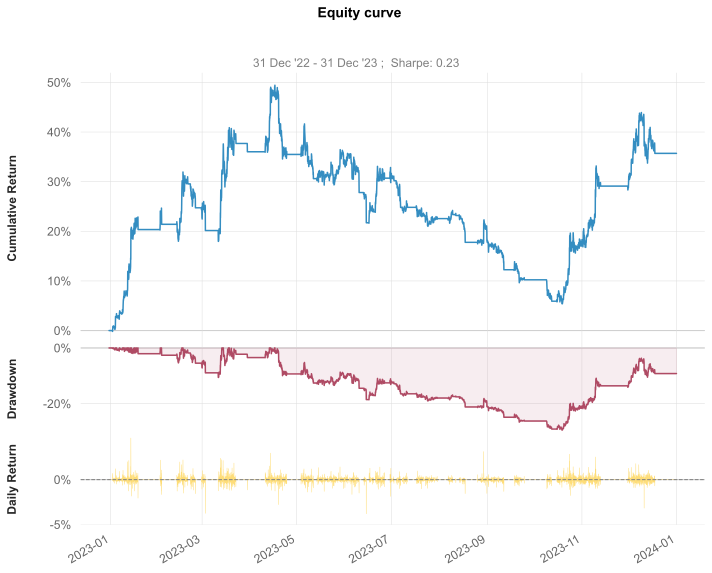

In [27]:
# Set Jupyter Notebook output mode parameters
# Used to avoid warnings
from tradeexecutor.backtest.notebook import setup_charting_and_output
setup_charting_and_output()

# Needed to improve the resolution of matplotlib chart used here
%config InlineBackend.figure_format = 'svg'

from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.visual.equity_curve import visualise_equity_curve

curve = calculate_equity_curve(state)
returns = calculate_returns(curve)
visualise_equity_curve(returns)

### Returns monthly breakdown

- Monthly returns
- Best day/week/month/year

/Users/h25/.virtualenvs/trade-executor-Ybzie68T-py3.11/lib/python3.11/site-packages/quantstats/stats.py:968: FutureWarning:

In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.



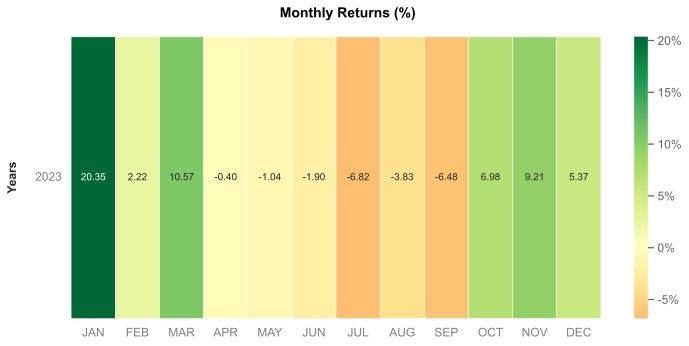

In [28]:
from tradeexecutor.visual.equity_curve import visualise_returns_over_time

visualise_returns_over_time(returns)

## Analysing  the strategy success

Here we calculate statistics on how well the strategy performed.

- Won/lost trades
- Timeline of taken positions with color coding of trade performance


In [29]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

### Strategy summary

Overview of strategy performance



In [30]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics()

with pd.option_context("display.max_row", None):
    display(summary.to_dataframe())

### Performance metrics

Here is an example how to use Quantstats library to calculate the tearsheet metrics for the strategy with advanced metrics. The metrics include popular risk-adjusted return comparison metrics.

This includes metrics like:

- Sharpe
- Sortino
- Max drawdown

**Note:** These metrics are based on equity curve and returns. Analysis here does not go down to the level of an individual trade or a position. Any consecutive wins and losses are measured in days, not in trade or candle counts.

In [31]:
from tradeexecutor.visual.equity_curve import calculate_equity_curve, calculate_returns
from tradeexecutor.analysis.advanced_metrics import visualise_advanced_metrics, AdvancedMetricsMode

equity = calculate_equity_curve(state)
returns = calculate_returns(equity)
metrics = visualise_advanced_metrics(returns, mode=AdvancedMetricsMode.full)

with pd.option_context("display.max_row", None):
    display(metrics)

Strategy
Start Period               2023-01-01
End Period                 2023-12-31
Risk-Free Rate                   0.0%
Time in Market                  56.0%
Cumulative Return               35.7%
CAGR﹪                          35.81%
Sharpe                           0.28
Prob. Sharpe Ratio             91.54%
Smart Sharpe                     0.28
Sortino                          0.41
Smart Sortino                    0.41
Sortino/√2                       0.29
Smart Sortino/√2                 0.29
Omega                            1.07
Max Drawdown                  -29.47%
Longest DD Days                   258
Volatility (ann.)                5.0%
Calmar                           1.22
Skew                             0.71
Kurtosis                        43.01
Expected Daily                   0.0%
Expected Monthly                2.58%
Expected Yearly                 35.7%
Kelly Criterion                 3.16%
Risk of Ruin                     0.0%
Daily Value-at-Risk            -0.43%
Expected Shortfall (cVaR)      -0.43%
Max Consecutive Wins               10
Max Consecutive Losses             10
Gain/Pain Ratio                  0.29
Gain/Pain (1M)                   1.68
Payoff Ratio                     1.06
Profit Factor                    1.07
Common Sense Ratio                1.1
CPC Index                        0.57
Tail Ratio                       1.03
Outlier Win Ratio                9.22
Outlier Loss Ratio               3.69
MTD                             5.37%
3M                             23.11%
6M                              3.29%
YTD                             35.7%
1Y                              35.7%
3Y (ann.)                      35.81%
5Y (ann.)                      35.81%
10Y (ann.)                     35.81%
All-time (ann.)                35.81%
Best Day                        4.63%
Worst Day                       -3.8%
Best Month                     20.35%
Worst Month                    -6.82%
Best Year                       35.7%
Worst Year                      35.7%
Avg. Drawdown                   -1.8%
Avg. Drawdown Days                  8
Recovery Factor                  1.21
Ulcer Index                      0.15
Serenity Index                   0.02
Avg. Up Month                   9.12%
Avg. Down Month                -3.41%
Win Days                       50.13%
Win Month                       50.0%
Win Quarter                     50.0%
Win Year                       100.0%

### Position and trade timeline

Display all positions and how much profit they made.

In [32]:
from tradeexecutor.analysis.trade_analyser import expand_timeline

timeline = analysis.create_timeline()

expanded_timeline, apply_styles = expand_timeline(
        universe.universe.exchanges,
        universe.universe.pairs,
        timeline)

# Do not truncate the row output
with pd.option_context("display.max_row", None):
    display(apply_styles(expanded_timeline))


## Finishing notes

Print out a line to signal the notebook finished the execution successfully.

In [33]:
print("All ok")

All ok
